# Spatial augmentation

Spatial augmentation (flips, affine transforms, elastic transforms) is
one of the most common and most important types of augmentation for
classification and segmentation tasks. Because they involve interpolation
of dense tensors, they are typically quite slow when applied on the CPU.

This notebook showcase the use of our geometric transforms, which can
be run on the GPU.

In [1]:
import torch
import matplotlib.pyplot as plt
from cornucopia.utils.py import meshgrid_ij
from cornucopia import (
    RandomAffineElasticTransform,
    RandomAffineTransform,
    RandomElasticTransform,
    RandomGaussianMixtureTransform,
)

Let's generate a synthetic label map. We use circles of varying radii.

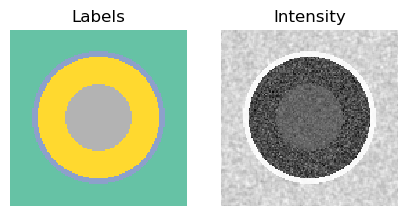

In [2]:
shape = [128, 128]
radius = torch.stack(meshgrid_ij(*[torch.arange(s).float() for s in shape]), -1)
radius -= (torch.as_tensor(shape).float() - 1) / 2
radius = radius.square().sum(-1).sqrt()

lab = torch.zeros_like(radius, dtype=torch.long)
lab[radius < 48] = 1
lab[radius < 44] = 2
lab[radius < 24] = 3
lab = lab[None]  # channel dimension

# we also generate an intenity image from this label map
img = RandomGaussianMixtureTransform()(lab)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(lab.squeeze(), cmap='Set2', interpolation='nearest')
plt.axis('off')
plt.title('Labels')
plt.subplot(1, 2, 2)
plt.imshow(img.squeeze(), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Intensity')
plt.show()

Then, instantiate a `RandomAffineElasticTransform` and apply it to our labels.
Note that tensors fed to a `Tranform` layer should have a channel dimension,
and no batch dimension.

In [3]:
RandomAffineElasticTransform?

Init signature:
RandomAffineElasticTransform(
    dmax=0.1,
    shape=5,
    steps=0,
    translations=0.1,
    rotations=15,
    shears=0.012,
    zooms=0.15,
    unit='fov',
    bound='border',
    patch=None,
    order=3,
    *,
    shared=True,
    shared_flow=None,
    **kwargs,
)
Docstring:      Random Affine + Elastic transform.
Init docstring:
Parameters
----------
dmax : Sampler or float
    Sampler or Upper bound for maximum displacement
shape : Sampler or int
    Sampler or Upper bounds for number of control points
steps : int
    Number of scaling-and-squaring integration steps
translations : Sampler or [list of] float
    Sampler or Upper bound for translation (per X/Y/Z)
rotations : Sampler or [list of] float
    Sampler or Upper bound for rotations (about Z/Y/X), in deg
shears : Sampler or [list of] float
    Sampler or Upper bound for shears (about Z/Y/Z)
zooms : Sampler or [list of] float
    Sampler or Upper bound for zooms about 1 (per X/Y/Z)
unit : {'fov', 'vox'}
  

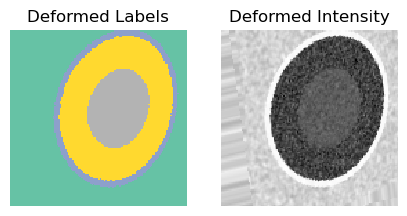

In [4]:
trf = RandomAffineElasticTransform()
wlab, wimg = trf(lab, img)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(wlab.squeeze(), cmap='Set2', interpolation='nearest')
plt.axis('off')
plt.title('Deformed Labels')
plt.subplot(1, 2, 2)
plt.imshow(wimg.squeeze(), cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Deformed Intensity')
plt.show()

Now, let's synthesize a bunch of them

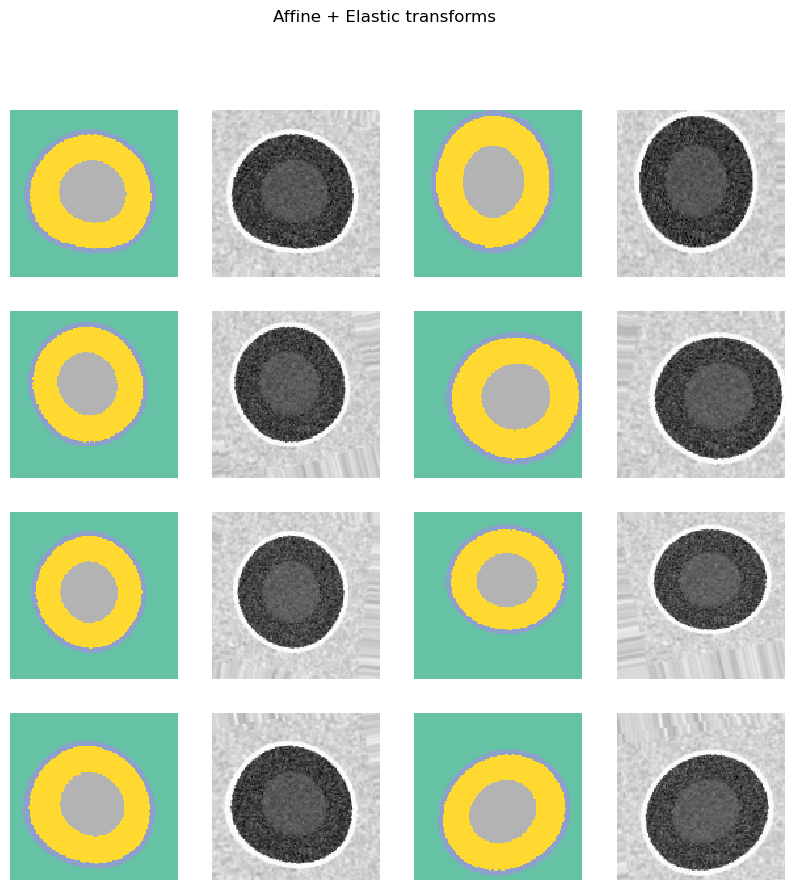

In [5]:
shape = [4, 4]

plt.figure(figsize=(10, 10))
for i in range(shape[0] * shape[1] // 2):
    wlab, wimg = trf(lab, img)
    plt.subplot(*shape, 2*i+1)
    plt.imshow(wlab.squeeze(), cmap='Set2', interpolation='nearest')
    plt.axis('off')
    plt.subplot(*shape, 2*i+2)
    plt.imshow(wimg.squeeze(), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.suptitle('Affine + Elastic transforms')
plt.show()

Let's do the same with only the Affine component

In [6]:
RandomAffineTransform?

Init signature:
RandomAffineTransform(
    translations=0.1,
    rotations=15,
    shears=0.012,
    zooms=0.15,
    unit='fov',
    bound='border',
    *,
    shared=True,
    shared_matrix=None,
    **kwargs,
)
Docstring:      Affine Transform with random parameters.
Init docstring:
Parameters
----------
translations : Sampler or [list of] float
    Sampler or Upper bound for translation (per X/Y/Z)
rotations : Sampler or [list of] float
    Sampler or Upper bound for rotations (about Z/Y/X), in deg
shears : Sampler or [list of] float
    Sampler or Upper bound for shears (about Z/Y/Z)
zooms : Sampler or [list of] float
    Sampler or Upper bound for zooms about 1 (per X/Y/Z)
unit : {'fov', 'vox'}
    Unit of `translations`.
bound : {'zeros', 'border', 'reflection'}
    Padding mode

Keyword Parameters
------------------
returns : [list or dict of] {'input', 'output', 'flow', 'matrix'}
    - 'input': The input image
    - 'output': The deformed image
    - 'flow': The displacement fi

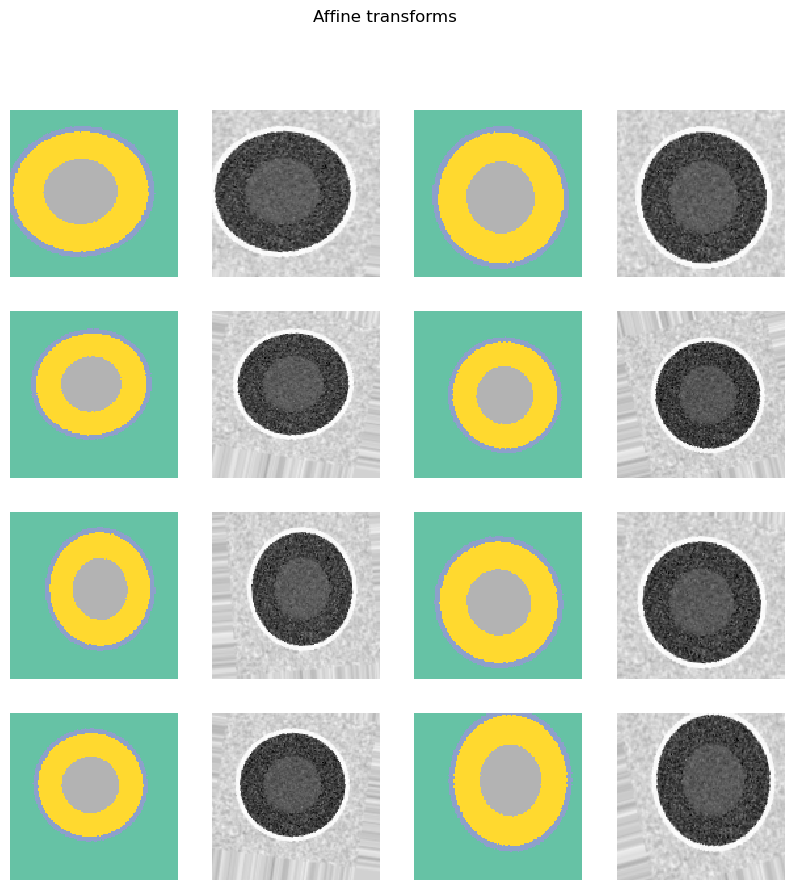

In [7]:
trf = RandomAffineTransform()
shape = [4, 4]

plt.figure(figsize=(10, 10))
for i in range(shape[0] * shape[1] // 2):
    wlab, wimg = trf(lab, img)
    plt.subplot(*shape, 2*i+1)
    plt.imshow(wlab.squeeze(), cmap='Set2', interpolation='nearest')
    plt.axis('off')
    plt.subplot(*shape, 2*i+2)
    plt.imshow(wimg.squeeze(), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.suptitle('Affine transforms')
plt.show()

And only the elastic component

In [8]:
RandomElasticTransform?

Init signature:
RandomElasticTransform(
    dmax=0.1,
    shape=5,
    unit='fov',
    bound='border',
    steps=0,
    order=3,
    *,
    shared=True,
    shared_flow=None,
    **kwargs,
)
Docstring:      Elastic Transform with random parameters.
Init docstring:
Parameters
----------
dmax : Sampler or float
    Sampler or Upper bound for maximum displacement
shape : Sampler or int
    Sampler or Upper bound for number of control points
unit : {'fov', 'vox'}
    Unit of `dmax`
bound : {'zeros', 'border', 'reflection'}
    Padding mode
order : int
    Spline order

Keyword Parameters
------------------
returns : [list or dict of] {'input', 'output', 'flow', 'controls'}
    - 'input': The input image
    - 'output': The deformed image
    - 'flow': The displacement field
    - 'controls': The control points of the displacement field
shared : {'channels', 'tensors', 'channels+tensors', ''}
    Whether to share random parameters across tensors and/or channels
shared_flow : {'channels', 't

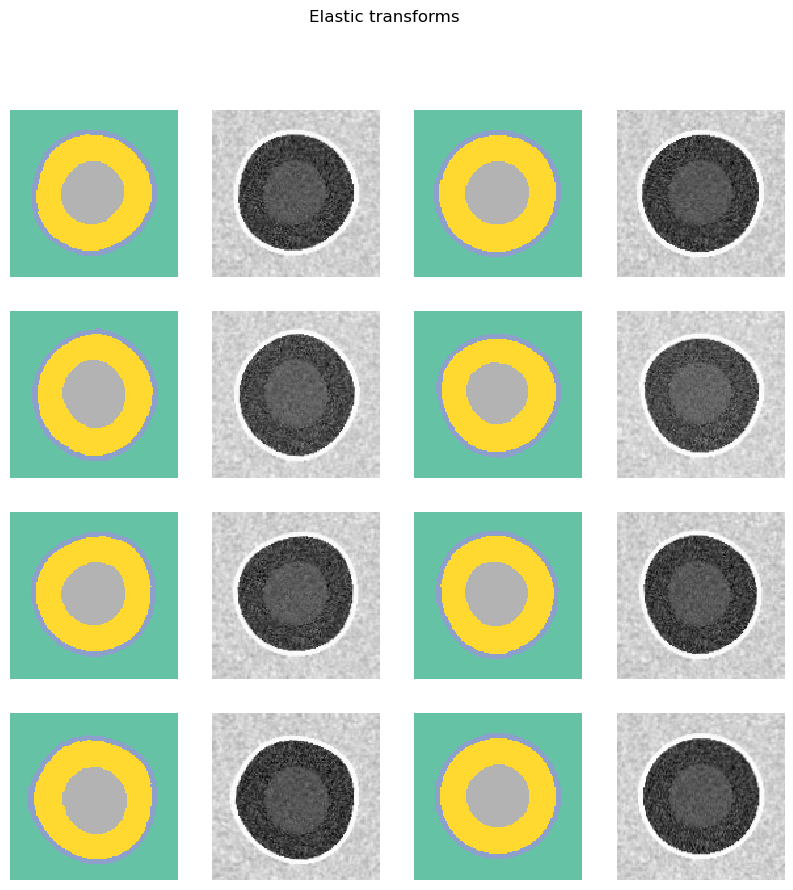

In [9]:
trf = RandomElasticTransform()
shape = [4, 4]

plt.figure(figsize=(10, 10))
for i in range(shape[0] * shape[1] // 2):
    wlab, wimg = trf(lab, img)
    plt.subplot(*shape, 2*i+1)
    plt.imshow(wlab.squeeze(), cmap='Set2', interpolation='nearest')
    plt.axis('off')
    plt.subplot(*shape, 2*i+2)
    plt.imshow(wimg.squeeze(), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.suptitle('Elastic transforms')
plt.show()

Note that it is also possible to sample different transformations 
across tensor (although it's usually not what you'd want to do when 
performing augmentation)

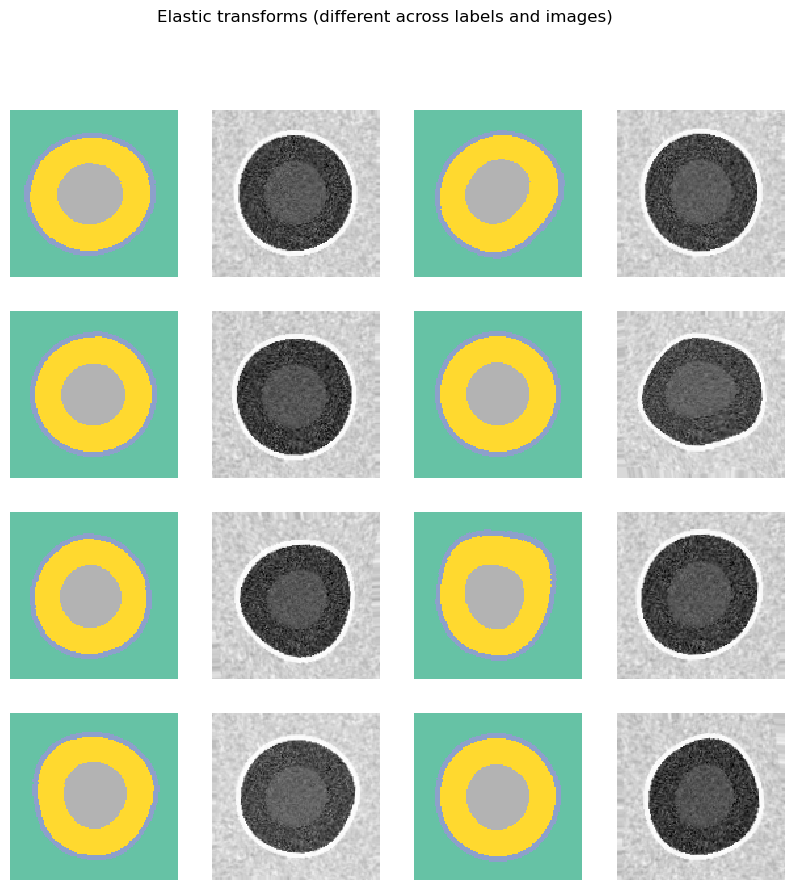

In [10]:
trf = RandomElasticTransform(shared=False)
shape = [4, 4]

plt.figure(figsize=(10, 10))
for i in range(shape[0] * shape[1] // 2):
    wlab, wimg = trf(lab, img)
    plt.subplot(*shape, 2*i+1)
    plt.imshow(wlab.squeeze(), cmap='Set2', interpolation='nearest')
    plt.axis('off')
    plt.subplot(*shape, 2*i+2)
    plt.imshow(wimg.squeeze(), cmap='gray', interpolation='nearest')
    plt.axis('off')
plt.suptitle('Elastic transforms (different across labels and images)')
plt.show()